<a href="https://colab.research.google.com/github/yutongwu10/ece6143-project/blob/main/Jet_Tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!pip install -q pyjet keras tables

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from pyjet import cluster, DTYPE_EP
import keras
from keras import utils, layers, models, optimizers, callbacks
from keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
import seaborn as sns
import tensorflow as tf

np.random.seed(42)

## Dataset

In [3]:
!wget https://zenodo.org/records/2603256/files/val.h5?download=1 -O val.h5

--2025-11-27 04:42:41--  https://zenodo.org/records/2603256/files/val.h5?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.153, 137.138.52.235, 188.185.48.75, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347378076 (331M) [application/octet-stream]
Saving to: ‘val.h5’

val.h5              100%[===================>] 331.29M  9.05MB/s    in 38s     

2025-11-27 04:43:20 (8.71 MB/s) - ‘val.h5’ saved [347378076/347378076]



In [4]:
data = pd.read_hdf("val.h5", key="table")

In [5]:
n_events = 10000

In [6]:
sig_progress = utils.Progbar(n_events)
sig_fatjets = []
for _, event in data[data['is_signal_new'] == 1].iloc[:n_events].iterrows():
    particles = np.zeros(200, dtype=DTYPE_EP)
    for i in range(200):
        particles[i] = (event[f"E_{i}"], event[f"PX_{i}"], event[f"PY_{i}"], event[f"PZ_{i}"])
    fatjets = cluster(particles, R=1.0, p=-1, ep=True).inclusive_jets(10)
    if len(fatjets) > 0:
        sig_fatjets.append(fatjets[0])
    sig_progress.add(1)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step


In [7]:
bkg_progress = utils.Progbar(n_events)
bkg_fatjets = []
for _, event in data[data['is_signal_new'] == 0].iloc[:n_events].iterrows():
    particles = np.zeros(200, dtype=DTYPE_EP)
    for i in range(200):
        particles[i] = (event[f"E_{i}"], event[f"PX_{i}"], event[f"PY_{i}"], event[f"PZ_{i}"])
    fatjets = cluster(particles, R=1.0, p=-1, ep=True).inclusive_jets(10)
    if len(fatjets) > 0:
        bkg_fatjets.append(fatjets[0])
    bkg_progress.add(1)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 51s 5ms/step


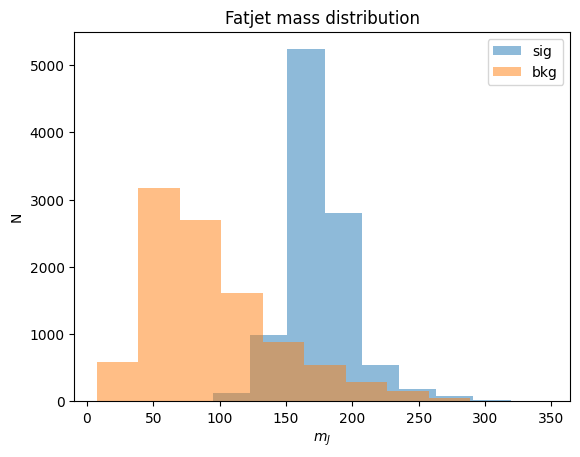

In [8]:
plt.hist([jet.mass for jet in sig_fatjets], alpha=0.5, label="sig")
plt.hist([jet.mass for jet in bkg_fatjets], alpha=0.5, label="bkg")
plt.xlabel("$m_{J}$")
plt.ylabel("N")
plt.title("Fatjet mass distribution")
plt.legend()
plt.show()

In [9]:
sig_progress = utils.Progbar(len(sig_fatjets))
sig_jet_images = []
for fatjet in sig_fatjets:
    constituents = fatjet.constituents_array()
    subjets = cluster(fatjet, algo="kt", R=0.3).inclusive_jets()
    if len(subjets) < 1:
        sig_progress.add(1)
        continue
    cst_pt = constituents["pT"]
    cst_eta = constituents["eta"]
    cst_phi = constituents["phi"]
    for i in range(len(cst_pt)):
        cst_eta[i] -= subjets[0].eta
        cst_phi[i] -= subjets[0].phi
    hist, _, _ = np.histogram2d(cst_eta, cst_phi, weights=cst_pt, bins=33, range=[(-1.6, 1.6), (-1.6, 1.6)])
    sig_jet_images.append(hist)
    sig_progress.add(1)
sig_jet_images = np.array(sig_jet_images)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 3s 265us/step


In [10]:
bkg_progress = utils.Progbar(len(bkg_fatjets))
bkg_jet_images = []
for fatjet in bkg_fatjets:
    constituents = fatjet.constituents_array()
    subjets = cluster(fatjet, algo="kt", R=0.3).inclusive_jets()
    if len(subjets) < 1:
        bkg_progress.add(1)
        continue
    cst_pt = constituents["pT"]
    cst_eta = constituents["eta"]
    cst_phi = constituents["phi"]
    for i in range(len(cst_pt)):
        cst_eta[i] -= subjets[0].eta
        cst_phi[i] -= subjets[0].phi
    hist, _, _ = np.histogram2d(cst_eta, cst_phi, weights=cst_pt, bins=33, range=[(-1.6, 1.6), (-1.6, 1.6)])
    bkg_jet_images.append(hist)
    bkg_progress.add(1)
bkg_jet_images = np.array(bkg_jet_images)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2s 230us/step


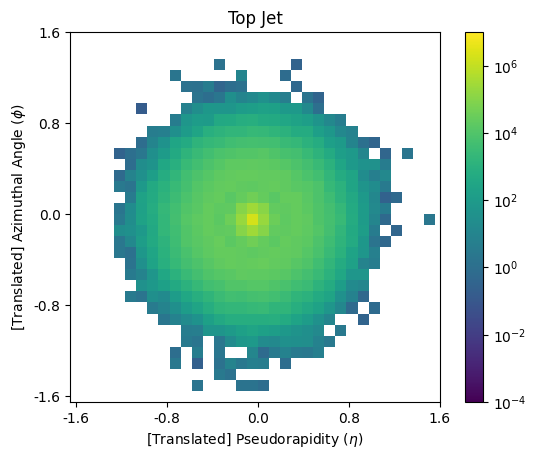

In [11]:
plt.imshow(sig_jet_images.sum(0).T, origin="lower", norm=colors.LogNorm(vmin=1e-4, vmax=1e7))
plt.xticks(np.linspace(0, 33, 5), np.linspace(-1.6, 1.6, 5).round(2))
plt.yticks(np.linspace(0, 33, 5), np.linspace(-1.6, 1.6, 5).round(2))
plt.title("Top Jet")
plt.xlabel(r'[Translated] Pseudorapidity ($\eta$)')
plt.ylabel(r'[Translated] Azimuthal Angle ($\phi$)')
plt.colorbar()
plt.show()

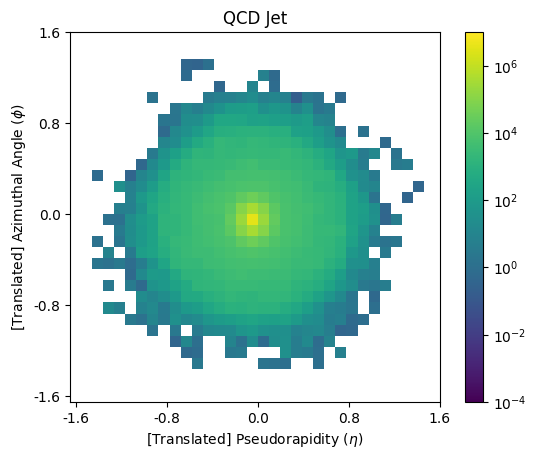

In [12]:
plt.imshow(bkg_jet_images.sum(0).T, origin="lower", norm=colors.LogNorm(vmin=1e-4, vmax=1e7))
plt.xticks(np.linspace(0, 33, 5), np.linspace(-1.6, 1.6, 5).round(2))
plt.yticks(np.linspace(0, 33, 5), np.linspace(-1.6, 1.6, 5).round(2))
plt.title("QCD Jet")
plt.xlabel(r'[Translated] Pseudorapidity ($\eta$)')
plt.ylabel(r'[Translated] Azimuthal Angle ($\phi$)')
plt.colorbar()
plt.show()

In [13]:
sig_jet_images = np.expand_dims(sig_jet_images, axis=-1)
bkg_jet_images = np.expand_dims(bkg_jet_images, axis=-1)

x = np.concatenate([sig_jet_images, bkg_jet_images], axis=0)
y = np.concatenate([np.ones(len(sig_jet_images)), np.zeros(len(bkg_jet_images))])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
y_train = utils.to_categorical(y_train, num_classes=2)
y_test = utils.to_categorical(y_test, num_classes=2)

print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (16000, 33, 33, 1)
x_test shape: (4000, 33, 33, 1)
y_train shape: (16000, 2)
y_test shape: (4000, 2)


## Model 1:CNN

In [14]:
inputs = layers.Input(shape=(33, 33, 1))
x_cnn = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
x_cnn = layers.MaxPooling2D(2)(x_cnn)
x_cnn = layers.Conv2D(64, 3, padding="same", activation="relu")(x_cnn)
x_cnn = layers.MaxPooling2D(2)(x_cnn)
x_cnn = layers.Conv2D(128, 3, padding="same", activation="relu")(x_cnn)
x_cnn = layers.MaxPooling2D(2)(x_cnn)
x_cnn = layers.Flatten()(x_cnn)
x_cnn = layers.Dense(64, activation="relu")(x_cnn)
outputs_cnn = layers.Dense(2, activation="softmax")(x_cnn)

model = models.Model(inputs, outputs_cnn, name="CNN")
model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 33, 33, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 33, 33, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,938 (874.76 KB)

 Trainable params: 223,938 (874.76 KB)

 Non-trainable params: 0 (0.00 B)

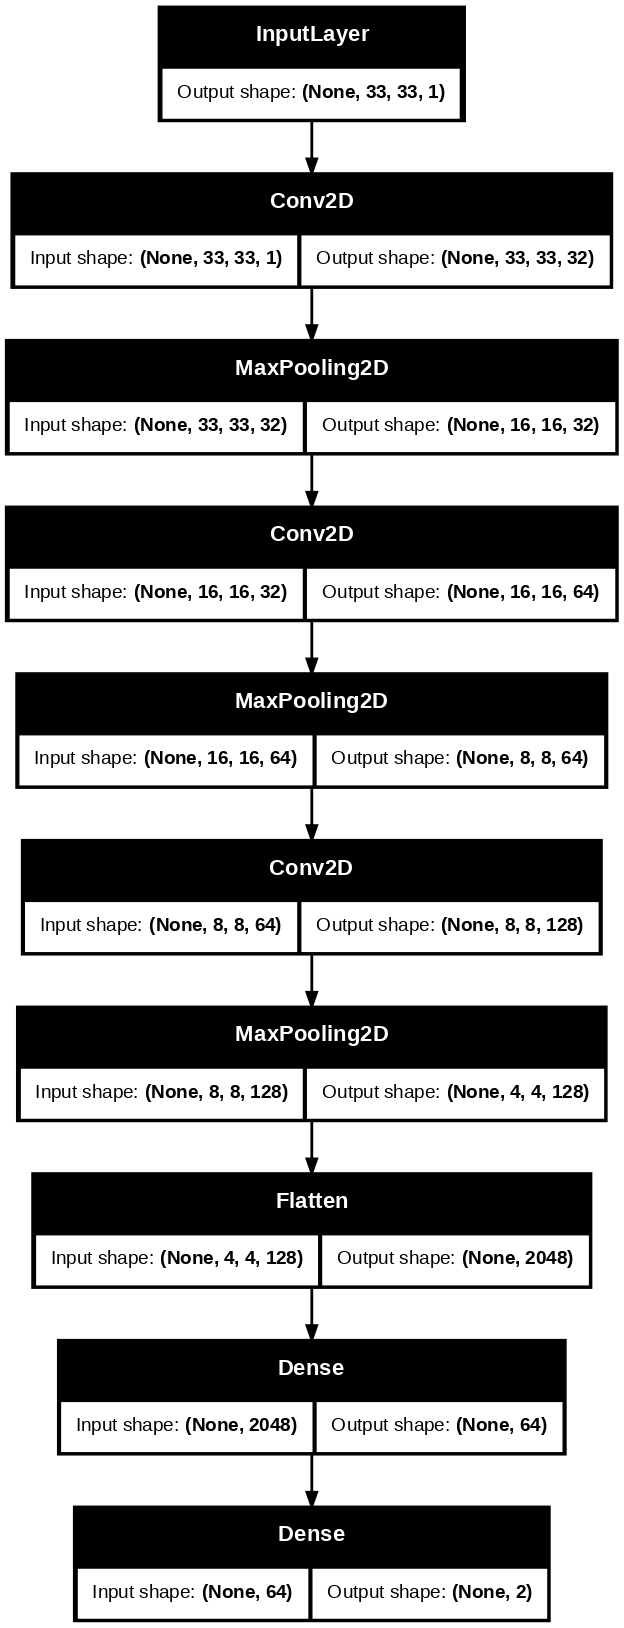

In [15]:
utils.plot_model(model, show_shapes=True, dpi=100)

## Training

In [16]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history_cnn = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8244 - loss: 0.6324 - val_accuracy: 0.8870 - val_loss: 0.2923
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8747 - loss: 0.3011 - val_accuracy: 0.8910 - val_loss: 0.2719
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8846 - loss: 0.2851 - val_accuracy: 0.8992 - val_loss: 0.2596
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8895 - loss: 0.2643 - val_accuracy: 0.8975 - val_loss: 0.2577
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8915 - loss: 0.2618 - val_accuracy: 0.8907 - val_loss: 0.2598
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8946 - loss: 0.2534 - val_accuracy: 0.8940 - val_loss: 0.2464
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9022 - loss: 0.2316 - val_accuracy: 0.8967 - val_loss: 0.2589
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9064 - loss: 0.2294 - val_accuracy: 0.


# Model 2: ResNet50 Fine-tuning






In [17]:
def preprocess_for_resnet(X):
    """(N, 33, 33, 1) → (N, 75, 75, 3)"""
    N = X.shape[0]
    X_out = np.zeros((N, 75, 75, 3))
    for i in range(N):
        img = X[i, :, :, 0]
        img = np.log1p(img)
        img_min, img_max = img.min(), img.max()
        if img_max > img_min:
            img = (img - img_min) / (img_max - img_min) * 255

        img_resized = tf.image.resize(img[:, :, np.newaxis], (75, 75)).numpy()
        X_out[i] = np.concatenate([img_resized, img_resized, img_resized], axis=-1)
    return X_out

print("Preparing ResNet50 data...")
x_train_resnet = preprocess_for_resnet(x_train)
x_test_resnet = preprocess_for_resnet(x_test)
print(f"x_train_resnet shape: {x_train_resnet.shape}")
print(f"x_test_resnet shape: {x_test_resnet.shape}")


# Build ResNet50 fine-tuning model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
base_model.trainable = False  # Freeze pre-trained layers

inputs_resnet = layers.Input(shape=(75, 75, 3))
x_res = base_model(inputs_resnet, training=False)
x_res = layers.GlobalAveragePooling2D()(x_res)
x_res = layers.Dense(256, activation='relu')(x_res)
x_res = layers.Dropout(0.5)(x_res)
outputs_resnet = layers.Dense(2, activation='softmax')(x_res)

model_resnet = models.Model(inputs_resnet, outputs_resnet, name="ResNet50_Finetune")
model_resnet.summary()


# Phase 1: Train classification head only
print("="*50)
print("ResNet50 Phase 1: Train classification head")
print("="*50)
model_resnet.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
history_resnet1 = model_resnet.fit(x_train_resnet, y_train, batch_size=32, epochs=10, validation_data=(x_test_resnet, y_test))


# Phase 2: Unfreeze top layers for fine-tuning
print("="*50)
print("ResNet50 Phase 2: Fine-tune top layers")
print("="*50)
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False



Preparing ResNet50 data...
x_train_resnet shape: (16000, 75, 75, 3)
x_test_resnet shape: (4000, 75, 75, 3)


Model: "ResNet50_Finetune"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 75, 75, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

ResNet50 Phase 1: Train classification head
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.7718 - loss: 0.5140 - val_accuracy: 0.8453 - val_loss: 0.3558
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8423 - loss: 0.3766 - val_accuracy: 0.8493 - val_loss: 0.3458
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8483 - loss: 0.3617 - val_accuracy: 0.8600 - val_loss: 0.3253
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8467 - loss: 0.3488 - val_accuracy: 0.8635 - val_loss: 0.3210
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8537 - loss: 0.3413 - val_accuracy: 0.8630 - val_loss: 0.3164
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8559 - loss: 0.3357 - val_accuracy: 0.8605 - val_loss: 0.3282
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8588 - loss: 0.3392 - val_accuracy: 0.8662 - val_loss: 0.3178
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22

## Training

In [18]:
model_resnet.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["accuracy"])
history_resnet2 = model_resnet.fit(x_train_resnet, y_train, batch_size=32, epochs=10, validation_data=(x_test_resnet, y_test))


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - accuracy: 0.7839 - loss: 0.7147 - val_accuracy: 0.8528 - val_loss: 0.3553
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.8633 - loss: 0.3262 - val_accuracy: 0.8583 - val_loss: 0.3534
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.8816 - loss: 0.2657 - val_accuracy: 0.8620 - val_loss: 0.3588
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.9009 - loss: 0.2282 - val_accuracy: 0.8470 - val_loss: 0.4036
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.9081 - loss: 0.1988 - val_accuracy: 0.8590 - val_loss: 0.3997
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.9247 - loss: 0.1719 - val_accuracy: 0.8583 - val_loss: 0.4291
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.9369 - loss: 0.1431 - val_accuracy: 0.8522 - val_loss: 0.4505
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.9487 - loss: 0.1245 - 

## Evaluation

In [19]:
def evaluate(model, X, y, name):
    y_pred = model.predict(X, verbose=0)
    y_pred_class = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y, axis=1)
    acc = accuracy_score(y_true, y_pred_class)
    fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
    auc_score = auc(fpr, tpr)
    return {'name': name, 'acc': acc, 'auc': auc_score, 'fpr': fpr, 'tpr': tpr,
            'y_pred': y_pred_class, 'y_true': y_true}

res_cnn = evaluate(model, x_test, y_test, "CNN")
res_resnet = evaluate(model_resnet, x_test_resnet, y_test, "ResNet50")

print("\n" + "="*50)
print("Results Comparison")
print("="*50)
print(f"{'Model':<15} {'AUC':<10} {'Accuracy':<10}")
print("-"*50)
print(f"{'CNN':<15} {res_cnn['auc']:<10.4f} {res_cnn['acc']*100:<10.2f}%")
print(f"{'ResNet50':<15} {res_resnet['auc']:<10.4f} {res_resnet['acc']*100:<10.2f}%")
print("="*50)



Results Comparison
Model           AUC        Accuracy  
--------------------------------------------------
CNN             0.9582     89.70     %
ResNet50        0.9221     85.15     %


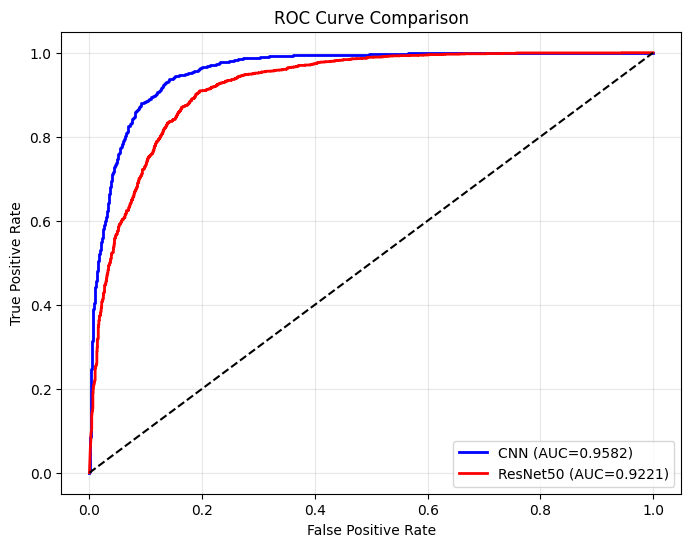

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(res_cnn['fpr'], res_cnn['tpr'], 'b-', lw=2, label=f"CNN (AUC={res_cnn['auc']:.4f})")
plt.plot(res_resnet['fpr'], res_resnet['tpr'], 'r-', lw=2, label=f"ResNet50 (AUC={res_resnet['auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('roc_comparison.png', dpi=150)
plt.show()

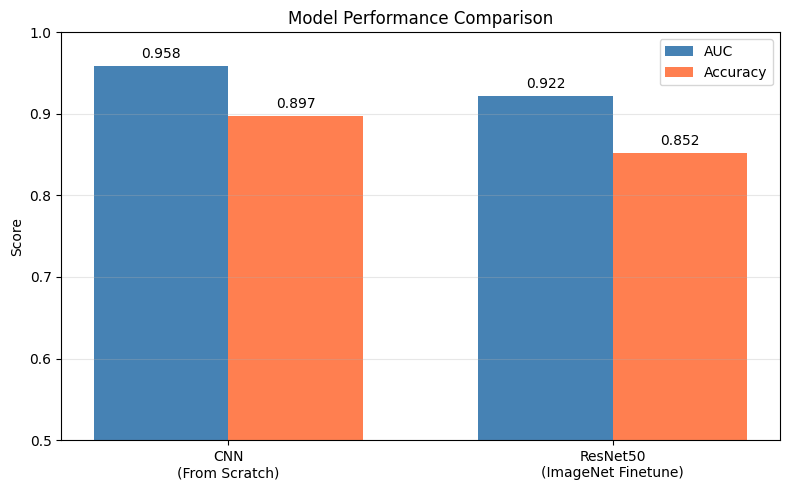

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))
x_pos = np.arange(2)
width = 0.35

bars1 = ax.bar(x_pos - width/2, [res_cnn['auc'], res_resnet['auc']], width, label='AUC', color='steelblue')
bars2 = ax.bar(x_pos + width/2, [res_cnn['acc'], res_resnet['acc']], width, label='Accuracy', color='coral')

ax.set_xticks(x_pos)
ax.set_xticklabels(['CNN\n(From Scratch)', 'ResNet50\n(ImageNet Finetune)'])
ax.set_ylim([0.5, 1.0])
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', fontsize=10)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('comparison_bar.png', dpi=150)
plt.show()

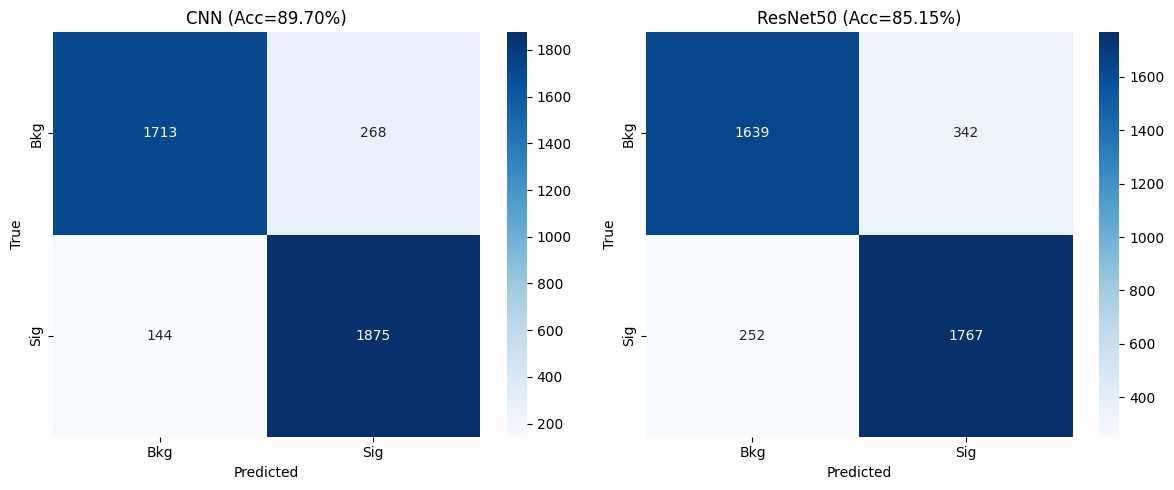

Done!


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, res in zip(axes, [res_cnn, res_resnet]):
    cm = confusion_matrix(res['y_true'], res['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Bkg', 'Sig'], yticklabels=['Bkg', 'Sig'])
    ax.set_title(f"{res['name']} (Acc={res['acc']:.2%})")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()


print("Done!")